# Face Recognition using Principal Component Analysis

The goal of implementing this system is to recognize a person's face by comparing it to a pre-existing database of faces, and identifying the closest match.

Link to paper on Eigenfaces: [https://sites.cs.ucsb.edu/~mturk/Papers/mturk-CVPR91.pdf](https://sites.cs.ucsb.edu/~mturk/Papers/mturk-CVPR91.pdf)

The AT&T face dataset contains a set of grayscale face images with dimensions 92x112. The images are organised in 40 directories (one for each subject), which have names of the form sX, where X indicates the subject number (between 1 and 40). In each of these directories, there are ten different images of that subject, which have names of the form Y.pgm, where Y is the image number for that subject (between 1 and 10). These 10 images per person are taken at different times, varying the lighting, facial expressions (open / closed eyes, smiling / not smiling) and facial details (glasses / no glasses). All the images were taken against a dark homogeneous background with the subjects in an upright, frontal position (with tolerance for some side movement). <b>Link:</b> [https://git-disl.github.io/GTDLBench/datasets/att_face_dataset/](https://git-disl.github.io/GTDLBench/datasets/att_face_dataset/)

#### Tasks
1. Load dataset and divide the date into training and test sets.
2. Implement the PCA algorithm from scratch.
3. Implement image reconstruction using the eigen projections and visualise differences for different number of components.
4. Visualise the mean(Eigen face) generated.
5. Given training set, obtain accuracy by attempting a face regonition module and obtaining the accuracy for different number of principal components.

#### Import Libraries

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os, sys
import cv2
from copy import copy
from tqdm import tqdm

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### Import Dataset
Assign labels for the images based on the subdirectories to obtain X(images array) and y (labels).

Ensure that the test data contains atleast one image from each category.

In [ ]:
#1 iterate through all folders, load each image

trainAmt = 0.9
allFaces = []
labels = []
folder_path = "/content/drive/MyDrive/ATnT"
for i in range(1,41):
    for j in range(1,11):
        imgPath = os.path.join(folder_path, "s" + str(i), str(j) + ".pgm")
        img = cv2.imread(imgPath, -1)

        allFaces.append(img)
        labels.append(i)

# shuffle
randomOrder = np.random.permutation(len(labels))
allFaces = np.array(allFaces)[randomOrder]
labels = np.array(labels)[randomOrder]

# split
trainFaces = allFaces[:int(trainAmt*len(allFaces))]
trainLabels = labels[:int(trainAmt*len(allFaces))]

testFaces = allFaces[int(trainAmt*len(allFaces)): ]
testLabels = labels[int(trainAmt*len(allFaces)): ]

# 112x92 (= 10304) grayscale images,  360 in train, 40 in test
print(trainFaces.shape, trainLabels.shape)

(360, 112, 92) (360,)


#### Implement PCA Algorithm.

Explain your steps with comments and write a brief explanation of the method.

In [ ]:
def principalComponentAnalysis(X, numComponents):
    """
    Implement pca in the following function by taking the following arguements:
    1. X(images array)
    2. number of components
    The function must return the eigen vectors (principal components) also termed "Eigen faces"
    """

    X = X.reshape(X.shape[0], X.shape[1] * X.shape[2])

    # Calculate mean face
    meanFace = np.mean(X, axis=0)

    # Subtract mean face from all faces
    X_centered = X - meanFace

    # Compute covariance matrix
    covariance_matrix = (X_centered @ X_centered.T) / len(X_centered)

    # Compute eigenvalues and eigenvectors
    eigenvalues, eigenvectors = np.linalg.eigh(covariance_matrix)
    eigenvectors = eigenvectors.T
    eigenvalues = eigenvalues[::-1]
    eigenvectors = eigenvectors[::-1]

    true_eigen_vec = np.empty(X_centered.shape)
    for i in range(len(eigenvectors)):
      true_eigen_vec[i] = eigenvectors[i].T @ X_centered
      true_eigen_vec[i] = (true_eigen_vec[i] / np.linalg.norm(true_eigen_vec[i]))

    return true_eigen_vec[:numComponents], meanFace

In [ ]:
def plotEigenFaces(eigenFaces, num_cols=5):
    num_faces = eigenFaces.shape[0]
    num_rows = num_faces // num_cols + (1 if num_faces % num_cols != 0 else 0)

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 10))

    for i in range(num_rows):
        for j in range(num_cols):
            idx = i * num_cols + j
            if idx < num_faces:
                axes[i, j].imshow(eigenFaces[idx].reshape(112, 92), cmap='gray')
                axes[i, j].axis('off')
                axes[i, j].set_title(f'Eigenface {idx+1}')
            else:
                axes[i, j].axis('off')

    plt.tight_layout()
    plt.show()


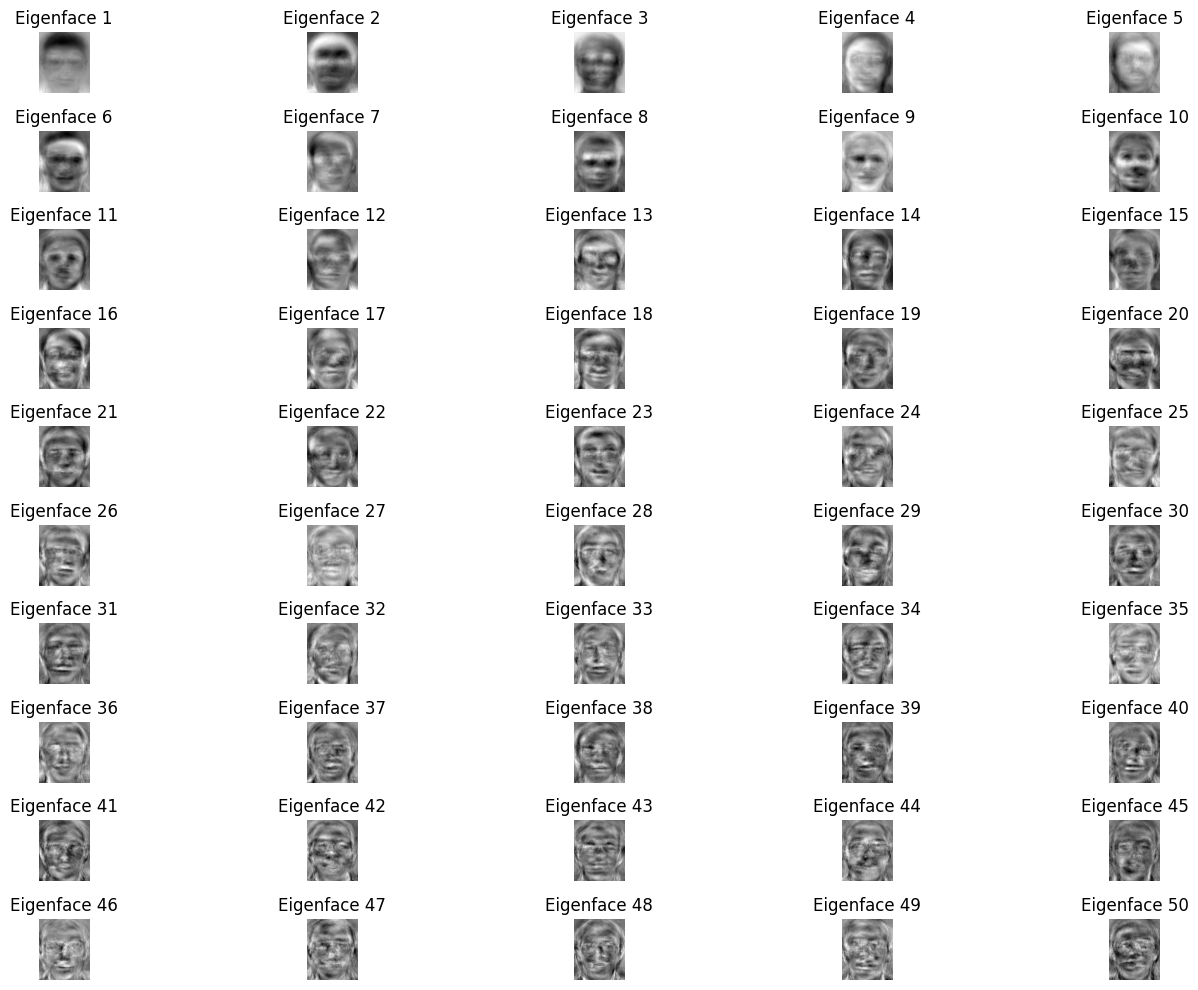

In [ ]:
# Calculate eigenfaces and meanface
eigen_faces, mean_face = principalComponentAnalysis(trainFaces, numComponents=50)
plotEigenFaces(eigen_faces)

#### Implement Image Reconstruction from Eigenfaces


Explain your steps with comments and write a brief explanation of the method.

In [ ]:
def imageReconstruction(testFace, eigenFaces, meanFace):
    """
    Helper function to reconstruct images
    """

    # Flatten test face
    testFace_flattened = testFace.flatten()

    # Subtract mean face from test face
    testFace_centered = testFace_flattened - meanFace

    # Compute projection coefficients
    projection_coefficients = np.dot(testFace_centered, eigenFaces.T)

    # Reconstruct face using selected eigenfaces
    reconstructed_face = meanFace + np.dot(projection_coefficients, eigenFaces)

    return reconstructed_face.reshape(testFace.shape)

In [ ]:
def plotReconstructions(testFace, eigenFaces, meanFace, numComponents_list):
    num_cols = len(numComponents_list) + 1
    num_rows = 1

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5))

    axes[0].imshow(testFace, cmap='gray')
    axes[0].set_title('Original Image')
    axes[0].axis('off')

    for i, numComponents in enumerate(numComponents_list):
        reconstructed_face = imageReconstruction(testFace, eigenFaces[:numComponents], meanFace)
        axes[i+1].imshow(reconstructed_face, cmap='gray')
        axes[i+1].set_title(f'{numComponents} Components')
        axes[i+1].axis('off')

    plt.tight_layout()
    plt.show()


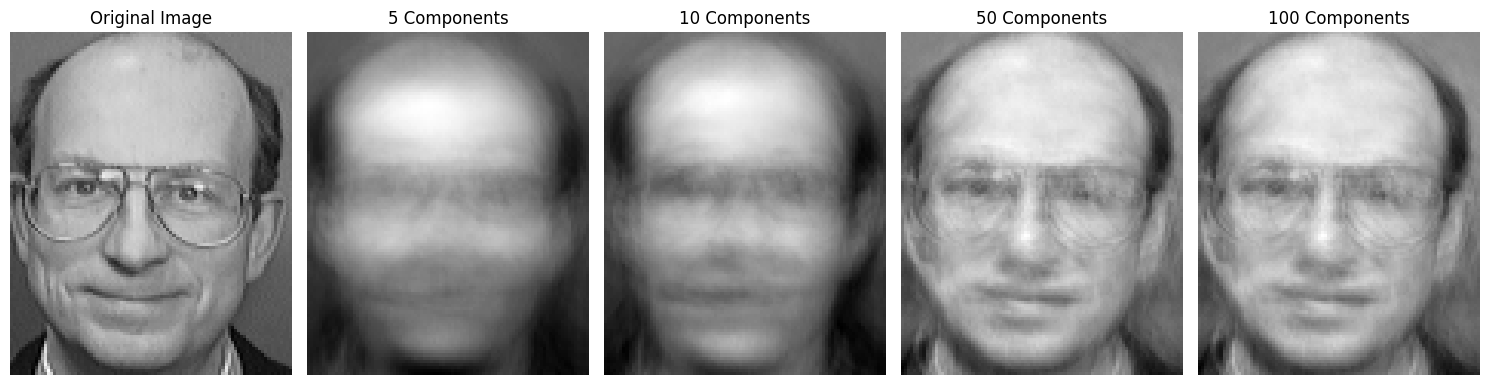

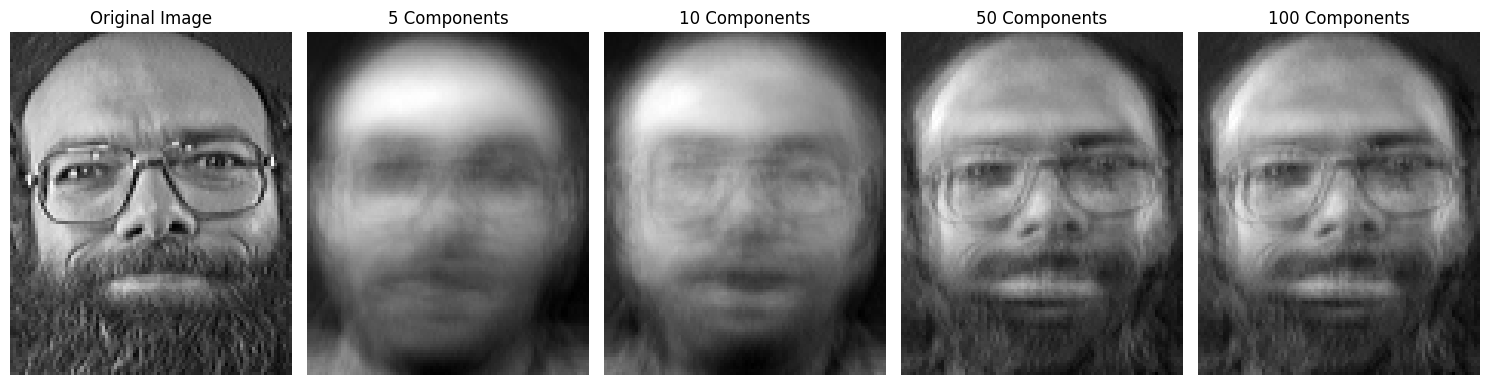

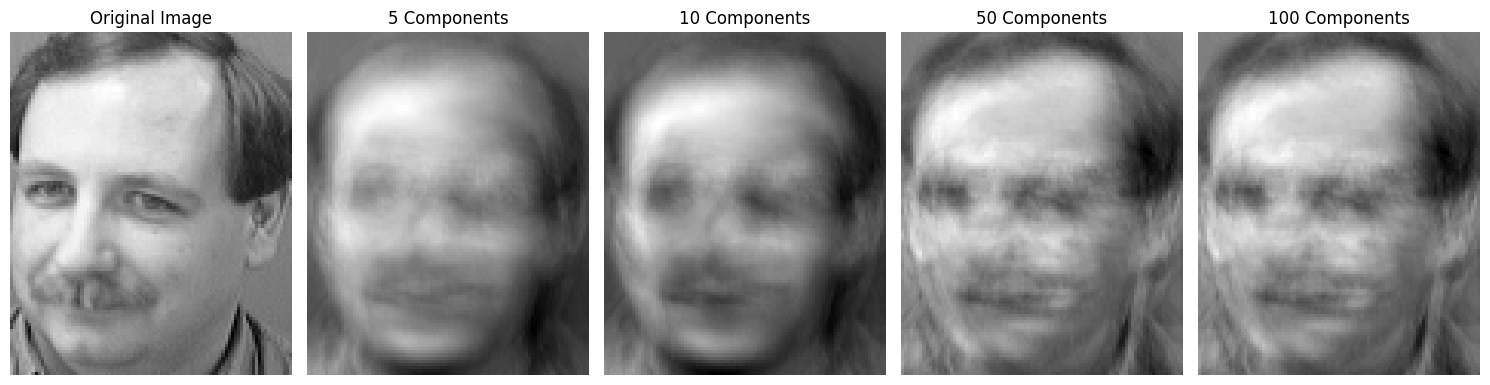

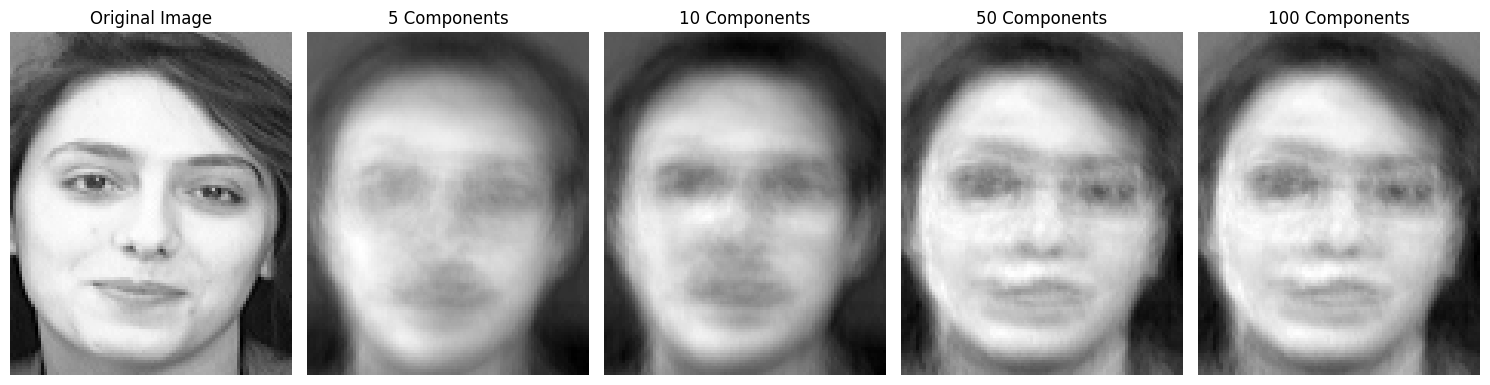

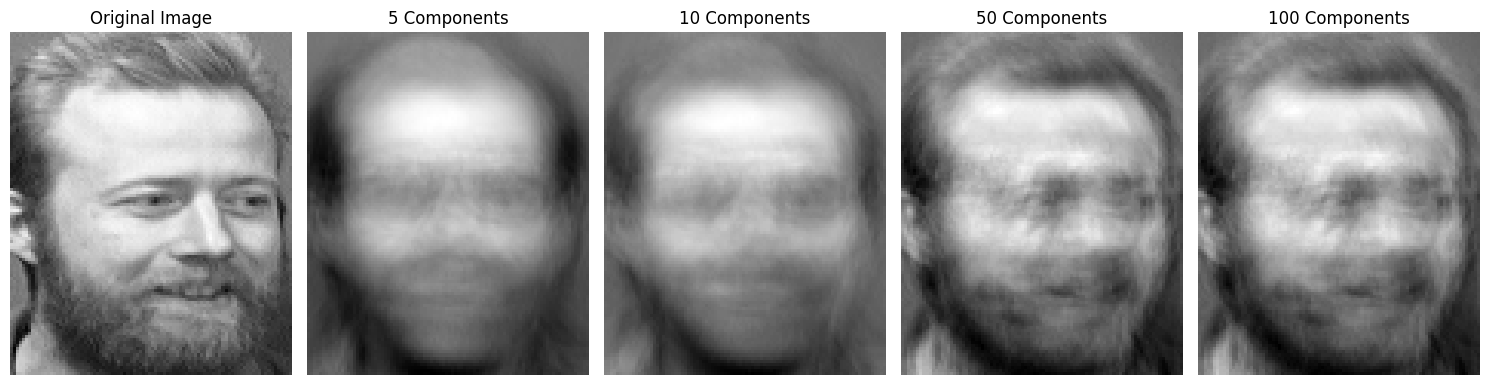

In [ ]:
 #plot recontructions here
%matplotlib inline

for i in range(0,5):
  testFace = trainFaces[i]
  numComponents_list = [5, 10, 50, 100]
  plotReconstructions(testFace, eigen_faces, mean_face, numComponents_list)

#### Visualisation
Visualise the results for different number of factors(pc = 5, 10, 50, 100, etc.)

**Note:** Ensure that the images are labelled appropriately.

In [ ]:
def displayNfactors(testFace, eigenFaces, meanFace, numComponents_list):
    fig, axes = plt.subplots(1, len(numComponents_list)+1, figsize=(20, 5))
    axes[0].imshow(testFace, cmap='gray')
    axes[0].set_title('Original Face')

    for i, numComponents in enumerate(numComponents_list):
        reconstructed_face = imageReconstruction(testFace, eigenFaces[:numComponents], meanFace)
        axes[i+1].imshow(reconstructed_face, cmap='gray')
        axes[i+1].set_title(f'{numComponents} Components')

    plt.show()


Test Face 1:


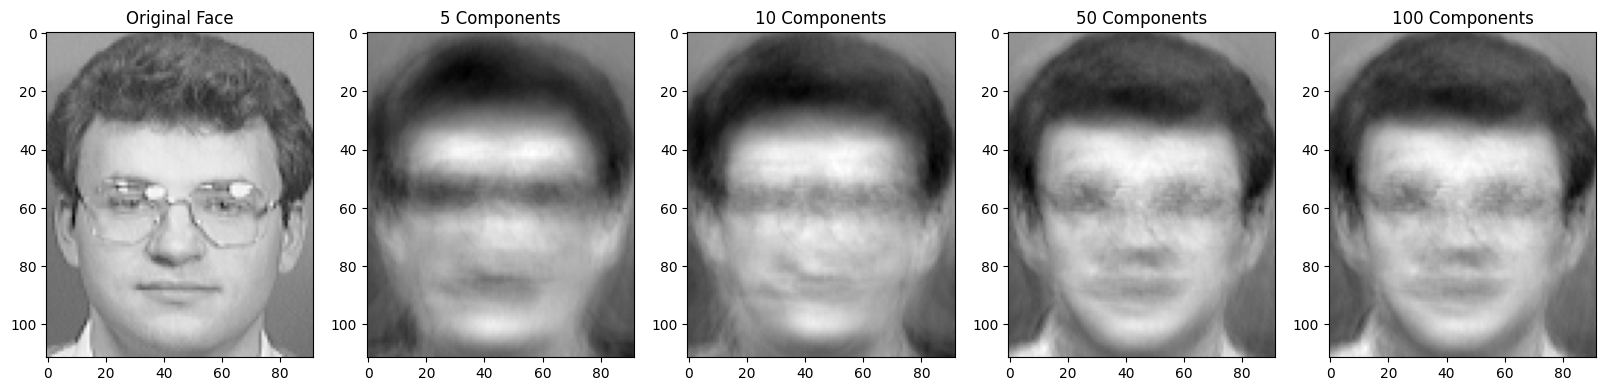

Test Face 2:


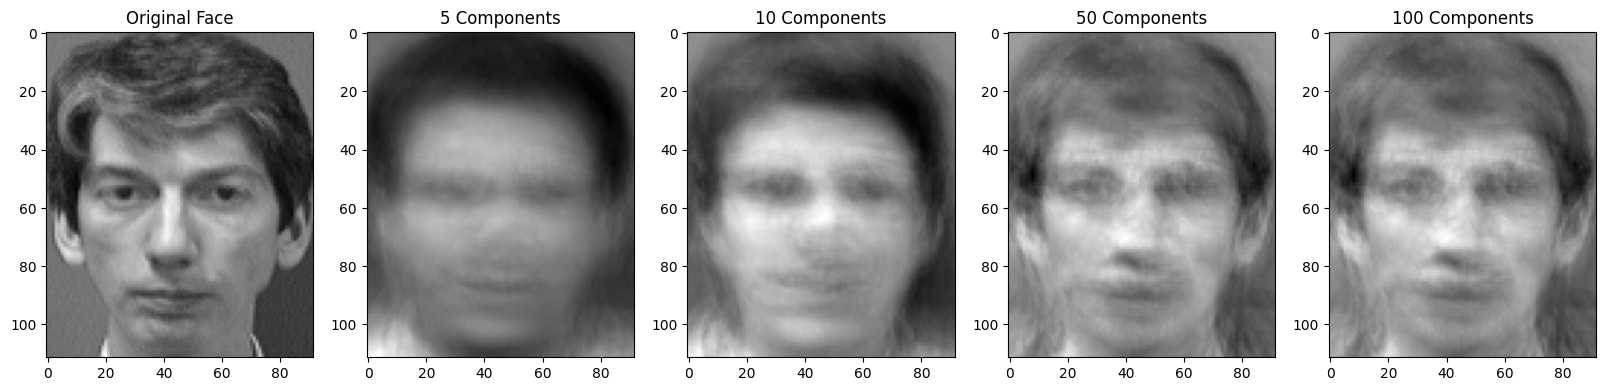

Test Face 3:


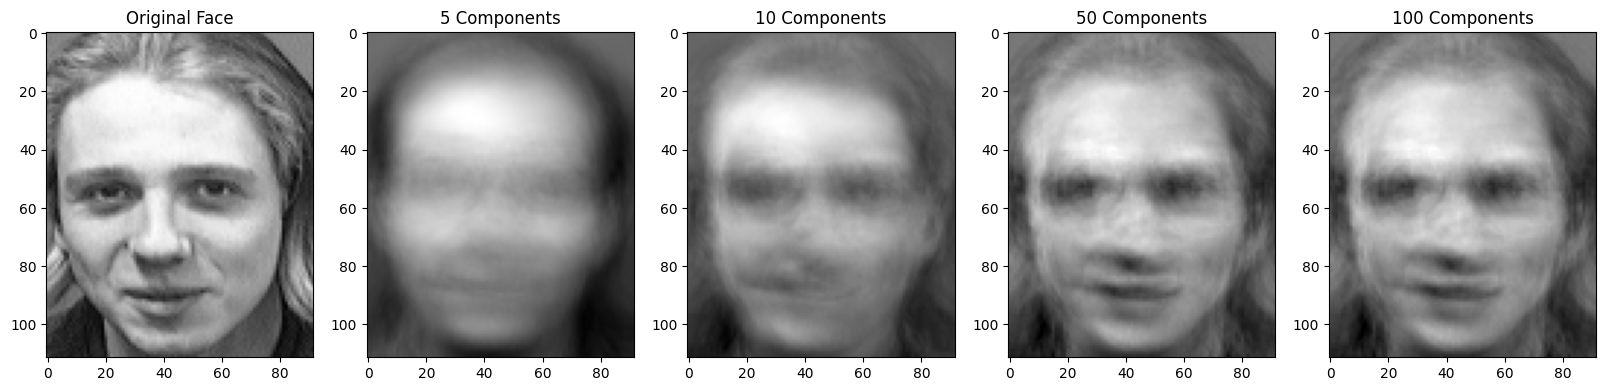

Test Face 4:


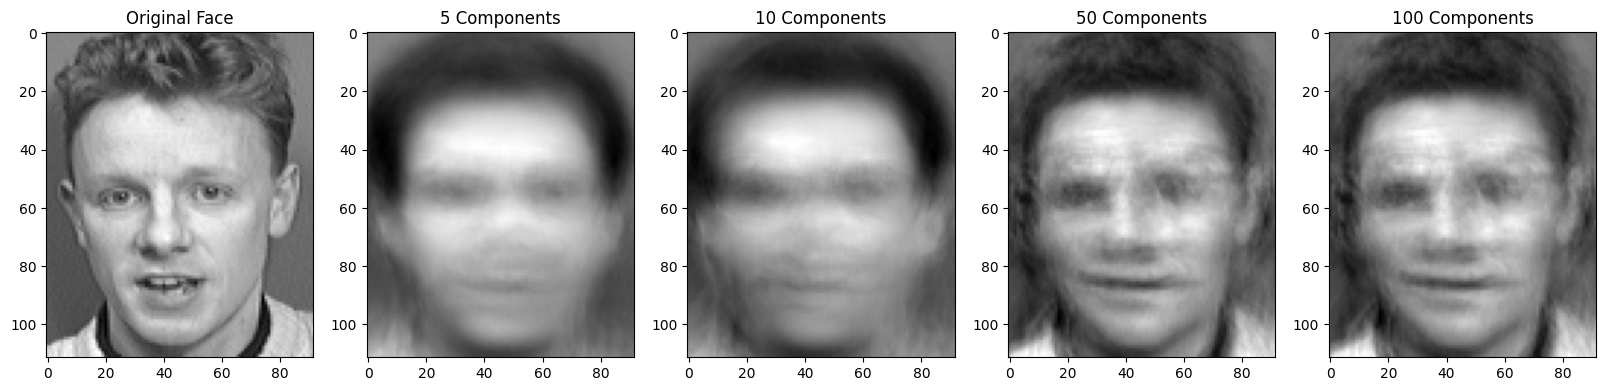

Test Face 5:


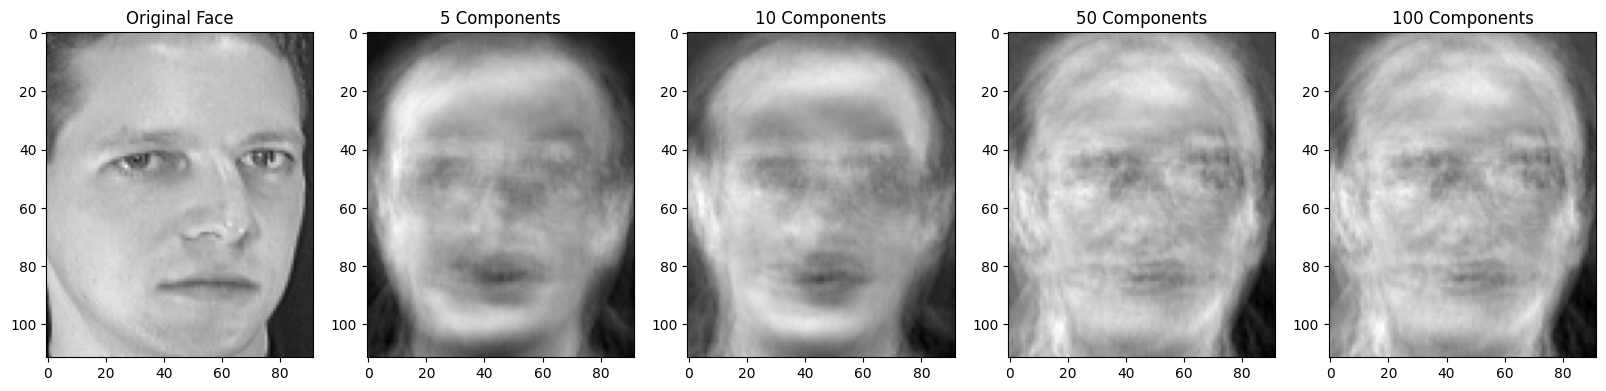

In [ ]:
%matplotlib inline

for i, testFace in enumerate(testFaces[:5]):
    print(f"Test Face {i+1}:")
    displayNfactors(testFace, eigen_faces, mean_face, [5, 10, 50, 100])

#### Implement face recognition module based on the norm
Explain your steps with comments and write a brief explanation of the method.

*   Test the module and report accuracies based on the number of components taken for a range of value and plot them.
*   Also plot the mean square error vs the number of eigenvectors taken and report your observations.
*   For further empirical analysis, plot the semi-log variant of the error plot obtained above.

In [ ]:
def getClass(testImage, eigenFaces, meanFace, X_train, y_train):
    """
    Arguments:
    1. Test image
    2. Eigenvectors
    3. Mean Eigen Face
    4. Training Set(X_train,y_train)

    Returns:
    1. closest_image: The image from the training set with the smallest reconstruction error.
    2. min_error: The smallest reconstruction error found.
    3. predicted_class: The predicted class label for the test image.
    """

    min_error = float('inf')
    predicted_class = None
    closest_image = None

    for i in range(len(X_train)):
        # Reconstruct the test image using eigenfaces
        reconstructed_face = imageReconstruction(testImage, eigenFaces, meanFace)

        # Compute the L2 norm (Euclidean distance) between the reconstructed face and each training face
        error = np.linalg.norm(reconstructed_face - X_train[i])

        # Update minimum error and predicted class if the current error is smaller
        if error < min_error:
            min_error = error
            predicted_class = y_train[i]
            closest_image = X_train[i]

    return closest_image, min_error, predicted_class

Iterate through all the images in the test data and test the accuracy by taking different number of components

In [ ]:
components = [3, 5, 10, 20, 30, 40, 50]
accuracies = []
error_images_dict = {num_components: [] for num_components in components}

for numComponents in components:
    correct_predictions = 0
    min_error = float('inf')
    min_error_image = None
    min_error_label = None
    total_tests = len(testFaces)

    for test_image, true_label in zip(testFaces, testLabels):
        closest_image, error, prediction = getClass(test_image, eigen_faces[:numComponents], mean_face, trainFaces, trainLabels)
        error_images_dict[numComponents].append((closest_image, error))
        if prediction == true_label:
            correct_predictions += 1

    accuracy = correct_predictions / total_tests
    accuracies.append(accuracy)
    print(f"Accuracy with {numComponents} components: {accuracy}")

Accuracy with 3 components: 0.225
Accuracy with 5 components: 0.525
Accuracy with 10 components: 0.8
Accuracy with 20 components: 0.975
Accuracy with 30 components: 0.975
Accuracy with 40 components: 0.975
Accuracy with 50 components: 0.975


Plot Number of eigenvectors vs Mean Square Error

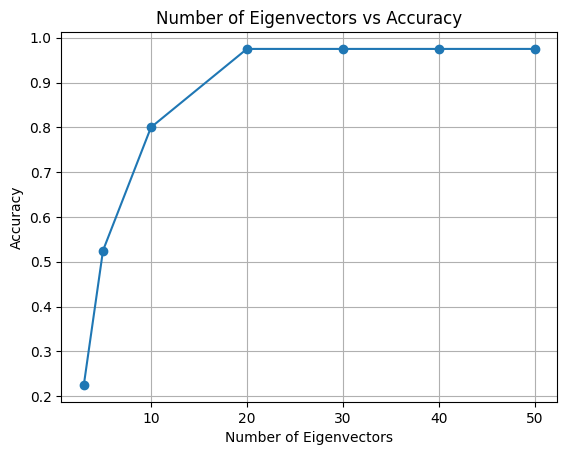

In [ ]:
# Plot Number of eigenvectors vs Accuracy

plt.plot(components, accuracies, marker='o')
plt.xlabel('Number of Eigenvectors')
plt.ylabel('Accuracy')
plt.title('Number of Eigenvectors vs Accuracy')
plt.grid(True)
plt.show()

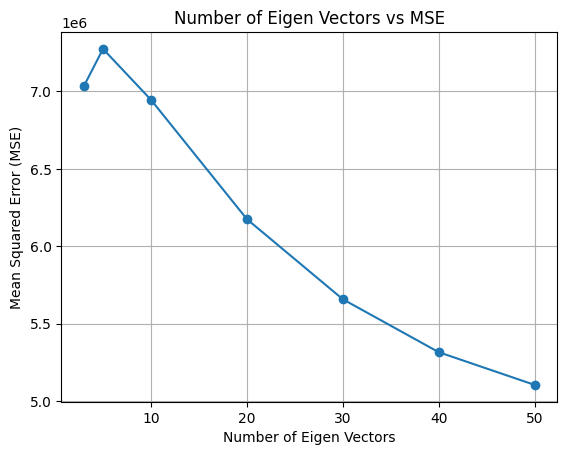

In [ ]:
mse = []
for numComponents in components:
    total_error = 0
    for _, error in error_images_dict[numComponents]:
        total_error += error ** 2
    mean_squared_error = total_error / len(testFaces)
    mse.append(mean_squared_error)

# Plot number of eigen vectors vs MSE
plt.plot(components, mse, marker='o')
plt.xlabel('Number of Eigen Vectors')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('Number of Eigen Vectors vs MSE')
plt.grid(True)
plt.show()

Plot Number of eigenvectors vs Logarithmic Mean Square Error

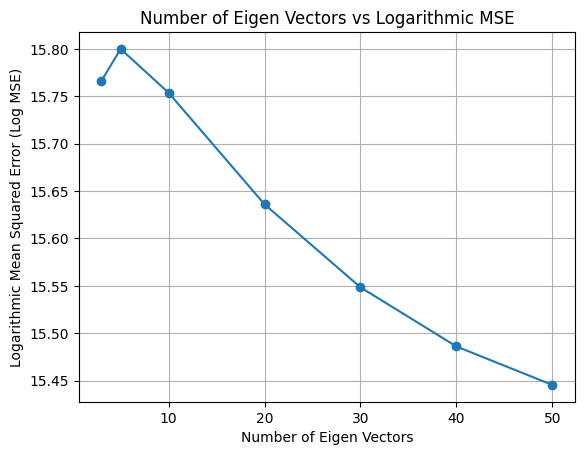

In [ ]:
# Calculate Logarithmic Mean Square Error (Log MSE) for each number of eigen vectors
log_mse = []
for numComponents in components:
    total_error = 0
    for _, error in error_images_dict[numComponents]:
        total_error += error ** 2
    mean_squared_error = total_error / len(testFaces)
    log_mean_squared_error = np.log(mean_squared_error)  # Compute logarithm of the MSE
    log_mse.append(log_mean_squared_error)

# Plot number of eigen vectors vs Logarithmic MSE
plt.plot(components, log_mse, marker='o')
plt.xlabel('Number of Eigen Vectors')
plt.ylabel('Logarithmic Mean Squared Error (Log MSE)')
plt.title('Number of Eigen Vectors vs Logarithmic MSE')
plt.grid(True)
plt.show()